# Load Dicom data and convert to numpy
## Data file organization


* /naomi/DATA/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA04_192_1
```
BraTS19_TCIA04_192_1_flair.nii.gz  
BraTS19_TCIA04_192_1_t1.nii.gz    
BraTS19_TCIA04_192_1_t2.nii.gz
BraTS19_TCIA04_192_1_seg.nii.gz    
BraTS19_TCIA04_192_1_t1ce.nii.gz
```

* Label 0: background
* Label 1: necrotic and non-enhancing tumor
* Label 2: edema # 부종
* Label 4: enhancing tumor

In [1]:
DATA= 'dicom/MICCAI_BraTS_2019_Data_Training/'
VALIDATION_DATA = 'dicom/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'/HGG/'
DATA_LGG = DATA +'/LGG/'

NUMPY_DIR = 'dicom/MICCAI_BraTS_2019_Data_Training/numpy_images/'
VALIDATION_NUMPY_DIR = 'dicom/MICCAI_BraTS_2019_Data_Validation/numpy_images/'
FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [2]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [3]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random

In [6]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.]#[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

## Visualization utils

In [7]:
from importlib import reload  # Python 3.4+ only.
import visualization_utils  as vu
reload(vu)

<module 'visualization_utils' from '/home/lab11/naomi/visualization_utils.py'>

In [8]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);
    

## Data utilities

In [9]:
def read_img_sitk(img):
    inputImage = sitk.ReadImage( img )
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    image = sitk.GetArrayFromImage(inputImage)
    return image

In [10]:
# ima files are of the form
# BraTS19_TCIA04_192_1_flair.nii.gz  
# BraTS19_TCIA04_192_1_t1.nii.gz    
# BraTS19_TCIA04_192_1_t2.nii.gz
# BraTS19_TCIA04_192_1_seg.nii.gz    
# BraTS19_TCIA04_192_1_t1ce.nii.gz

def read_image_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((4, 155, 240, 240), dtype=np.float32)
    
    ## Flair
    flair_img = os.path.join(dirpath, img_id+'_flair.nii.gz')
    if (not os.path.isfile(flair_img)):
        print(flair_img,' not found aborting')
        return None
    np_image[0] = read_img_sitk(flair_img)
        
    ## T1
    t1_nb4_img = os.path.join(dirpath, img_id+'_t1_nb4.nii.gz')
    if (not os.path.isfile(t1_nb4_img)):
        #print(t1_nb4_img,' not found')
        t1_img = os.path.join(dirpath, img_id+'_t1.nii.gz')
        if (not os.path.isfile(t1_img)):
            print(t1_img,' not found aborting')
            return None
        np_image[1] = read_img_sitk(t1_img)
    else:
        np_image[1] = read_img_sitk(t1_nb4_img)    
            
    ## T1CE
    t1ce_nb4_img = os.path.join(dirpath, img_id+'_t1ce_nb4.nii.gz')
    if (not os.path.isfile(t1ce_nb4_img)):
        #print(t1ce_nb4_img,' not found')
        t1ce_img = os.path.join(dirpath, img_id+'_t1ce.nii.gz')
        if (not os.path.isfile(t1ce_img)):
            print(t1ce_img,' not found aborting')
            return None
        np_image[2] = read_img_sitk(t1ce_img)
    else:
        np_image[2] = read_img_sitk(t1ce_nb4_img)    
    
        
    ## T2
    t2_img = os.path.join(dirpath, img_id+'_t2.nii.gz')
    if (not os.path.isfile(t2_img)):
        print(t2_img,' not found aborting')
        return None
    np_image[3] = read_img_sitk(t2_img)

    return np_image

In [11]:
def read_lable_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((155, 240, 240), dtype=np.int)
    
    ## lable
    lable_img = os.path.join(dirpath, img_id+'_seg.nii.gz')
    if (not os.path.isfile(lable_img)):
        print(lable_img,' not found aborting')
        return None
    np_image = read_img_sitk(lable_img).astype(int)

    return np_image

## Load data and Collect train data info

In [12]:
hgg_paths = []
for dirpath, dirnames, files in os.walk(DATA_HGG):
    if ('BraTS19' in dirpath):
        hgg_paths.append(dirpath)

lgg_paths = []
for dirpath, dirnames, files in os.walk(DATA_LGG):
    if ('BraTS19' in dirpath):
        lgg_paths.append(dirpath)
        
val_paths = []
for dirpath, dirnames, files in os.walk(VALIDATION_DATA):
    if ('BraTS19' in dirpath):
        val_paths.append(dirpath)

In [13]:
len(lgg_paths),len(hgg_paths),len(val_paths)

(76, 259, 125)

In [14]:
def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return [rmin, rmax, cmin, cmax, zmin, zmax]

### View some data

In [23]:
np_img = read_image_into_numpy('dicom/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA04_192_1')

<Figure size 432x360 with 0 Axes>

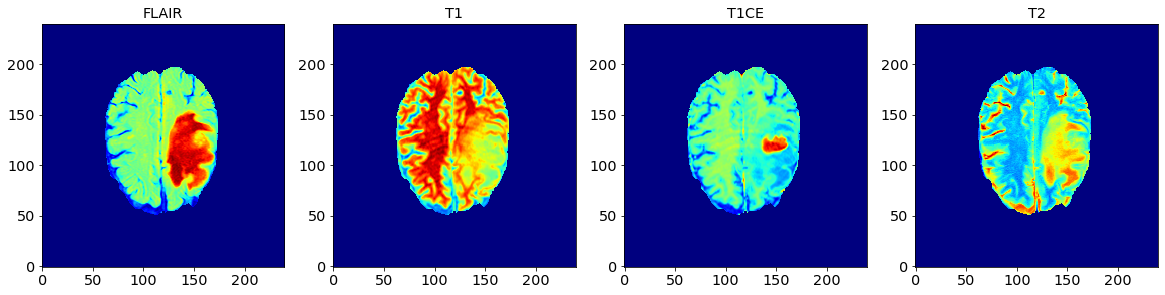

In [24]:
vu.show_n_images(np_img[:,100,:,:], titles=img_type)

In [25]:
np_lbl = read_lable_into_numpy('dicom/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA04_192_1')

<Figure size 432x360 with 0 Axes>

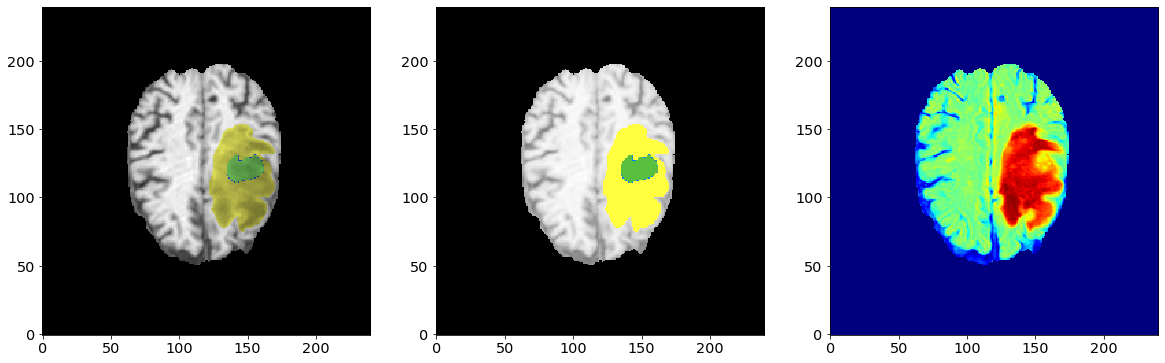

In [26]:
img1 = vu.show_lable_on_image4(np_img[1,100,:,:], np_lbl[100])
img2 = vu.show_lable_on_image(np_img[1,100,:,:], np_lbl[100])
vu.show_n_images([img1,img2,np_img[0,100]])

### Read all images collect data and save as numpy

There are 259 photos in train data, each has segmentation labeling file, with the following lables:

Label 0: background
Label 1: necrotic and non-enhancing tumor
Label 2: edema
Label 4: enhancing tumor
In the data preprocessing stage, I converted and merged the nii.gz files, to anumpy file of the format:

(155, 240, 240, 4) For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

> Lables are 1, 2 and 4.
So we will save 4 as 3.
#### Dont forget to set it back to 4 prior submission to Brats.



In [27]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [28]:
df = pd.DataFrame(columns=['Grade','id','lab0','lab1','lab2','lab3',
                           'rmin','rmax','cmin','cmax','zmin','zmax'])

In [29]:
def fill_df_from_path(df, paths = hgg_paths, grade='HGG'):
    
    for f in paths:
        np_img = read_image_into_numpy(f)
        np_lbl = read_lable_into_numpy(f)
        assert(np_lbl[np_lbl==3].sum()==0)
        np_lbl = np.where(np_lbl==4, 3, np_lbl)

        
        new_img = np.zeros((155, 240, 240,4))
        for i in range(4):
            new_img[:,:,:,i] = np_img[i, :,:,:] 
            
        nimg = os.path.join(NUMPY_DIR,  os.path.basename(f)+'.npy')
        np.save(nimg, new_img)
        nlbl = os.path.join(NUMPY_DIR,  os.path.basename(f)+'_lbl.npy')
        np.save(nlbl, np_lbl)

        lbls, repeats = np.unique(np_lbl, return_counts=True)
        lbl_counts=[0,0,0,0]
        for i in range(len(repeats)):
            lbl_counts[lbls[i]] = repeats[i]
        

        vals = [grade] + [os.path.basename(f)] + lbl_counts + bbox2_3D(np_lbl)
        
        df.loc[len(df)] = vals
        
    return df

In [32]:
df = fill_df_from_path(df, paths = lgg_paths, grade='LGG')
df = fill_df_from_path(df, paths = hgg_paths)

In [33]:
df.shape

(335, 12)

In [34]:
df[['lab' +str(i) for i in range(1,4)]].sum()

lab1     7566423.0
lab2    19290531.0
lab3     6260157.0
dtype: float64

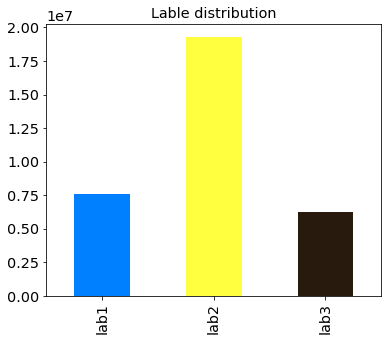

In [36]:
df[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution')

### Process validation data

In [37]:
df_val = pd.DataFrame(columns=['id','lab0','lab1','lab2','lab3'])

In [38]:
def fill_df_from_path(df=df_val, paths = val_paths):
    
    for f in paths:
        np_img = read_image_into_numpy(f)

        new_img = np.zeros((155, 240, 240,4))
        for i in range(4):
            new_img[:,:,:,i] = np_img[i, :,:,:] 

        nimg = os.path.join(VALIDATION_NUMPY_DIR,  os.path.basename(f)+'.npy')
        np.save(nimg, new_img)
        
        vals = [os.path.basename(f)]+[0,0,0,0]
        df.loc[len(df)] = vals
        
    return df

In [40]:
df_val = fill_df_from_path(df_val, paths = val_paths)

## Split data to train-test and save

In [41]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)

In [42]:
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv',index=False)
df_val.to_csv('df_val.csv' ,index=False)